In [1]:
###Importing packages we need###

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.cm import get_cmap
from matplotlib.colors import LinearSegmentedColormap
import metpy.calc as mpcalc
from metpy.units import units
from matplotlib.lines import Line2D
from numpy import *
import xarray as xr
from netCDF4 import Dataset, num2date
import math
import pygrib
import matplotlib.patches as patches
import cdsapi
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import metpy as mp
import os
import warnings
warnings.filterwarnings("ignore")

print("Done importing modules")

Done importing modules


In [74]:
###Import the 3 CF tables and concatenate###

#Read in the 3 tables#
dfg = pd.read_csv('/projects/zami4053/Synoptic_Research/CSV_DFs/CF_good.csv')
dfmf = pd.read_csv('/projects/zami4053/Synoptic_Research/CSV_DFs/CF_mf_updated.csv')
dfu = pd.read_csv('/projects/zami4053/Synoptic_Research/CSV_DFs/CF_unclear_updated_new.csv')
                  
#Combine into 1 big file with all CF cases and reset index#
dfall = pd.concat([dfg, dfmf, dfu])
dfall.reset_index(drop=True, inplace=True)
#dfall

#Sort the DataFrame by 'date' and del duplicate#
dfall_sort = dfall.sort_values(by='date').reset_index(drop=True)
dfall_sort = dfall_sort.drop(260)
dfall_sort = dfall_sort.sort_values(by='date').reset_index(drop=True)
dfall_sort


##Further analysis by dataset subsetting##

# #Organize by month#
# dfall['date'] = pd.to_datetime(dfall['date'])
# dfall['month'] = dfall['date'].dt.month

# fall_df = dfall[dfall['month'].isin([9, 10, 11])]
# winter_df = dfall[dfall['month'].isin([12, 1, 2])]
# spring_df = dfall[dfall['month'].isin([3, 4, 5])]

#Organize by Low and High Precipitation Events#
df_LP = pd.read_csv('/projects/zami4053/Synoptic_Research/CSV_DFs/CF_Low_Precip.csv')
df_HP = pd.read_csv('/projects/zami4053/Synoptic_Research/CSV_DFs/CF_High_Precip.csv')
df_All = pd.read_csv('/projects/zami4053/Synoptic_Research/CSV_DFs/CF_All_Precip.csv')

df_select = df_LP.copy()
df_select

,date,max_value,max_time,file_date,total_precip
0,1950-11-02,625.744615,1950-11-01 10:00:00,1950-11-02,0.039172
1,1950-12-27,1011.129758,1950-12-26 15:00:00,1950-12-27,61.792616
2,1951-01-28,2451.093687,1951-01-27 05:00:00,1951-01-28,4.875601
3,1951-03-09,5164.179325,1951-03-08 09:00:00,1951-03-09,9.902985
4,1951-03-24,2864.818543,1951-03-23 08:00:00,1951-03-24,13.509710
...,...,...,...,...,...
140,2021-11-01,672.486578,2021-10-31 06:00:00,2021-11-01,15.182394
141,2021-11-09,393.261911,2021-11-09 02:00:00,2021-11-09,9.922114
142,2021-11-18,3125.050762,2021-11-17 10:00:00,2021-11-18,62.295407
143,2021-12-07,10677.291980,2021-12-06 01:00:00,2021-12-07,7.024482


In [75]:
###Try importing the climo files from Andrew###

df_climo = xr.open_dataset('/pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/Climos_REV/climo_850hPatemp_mean.nc')
df_climo


<xarray.Dataset>
Dimensions:  (lat: 361, lon: 1440, time: 365)
Coordinates:
  * lat      (lat) float32 90.0 89.75 89.5 89.25 89.0 ... 1.0 0.75 0.5 0.25 0.0
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 1979-12-31
Data variables:
    t        (time, lat, lon) float64 ...
Attributes:
    title:    Climatological 850-hPa Temperature 1979-2022

In [76]:
###Extract the max times so we can use them for compositing###

#Pull out the max time column#
max_times = list(df_select['max_time'].values)
dates = list(df_select['date'].values)
N = len(max_times)

max_times[0:10], print(N)


145


(['1950-11-01 10:00:00',
  '1950-12-26 15:00:00',
  '1951-01-27 05:00:00',
  '1951-03-08 09:00:00',
  '1951-03-23 08:00:00',
  '1951-09-11 12:00:00',
  '1951-10-15 14:00:00',
  '1951-10-30 17:00:00',
  '1953-01-28 01:00:00',
  '1953-10-03 08:00:00'],
 None)

In [77]:
# ds_testing = xr.open_dataset('/pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_Comp_largedomain/pressure_level_vars/pl_winds/ERA5_pl_winds_01_01_2011.nc')
# ds_testing

# #Read u and v wind components#
# u = ds_testing['u']
# v = ds_testing['v']

# #Calculate wind speed#
# wind_speed = np.sqrt(u**2 + v**2)

# wind_speed

# #Add wind speed to the dataset#
# ds_testing['wind_speed'] = (('time', 'level', 'latitude', 'longitude'), wind_speed.data)
# ds_testing['wind_speed'].attrs['units'] = 'm/s'
# ds_testing['wind_speed'].attrs['long_name'] = 'Wind Speed'

# ds_testing['wind_speed'][400, 0, :, :].plot()

In [78]:
# ###Function to calculate wind speed and add it to the netCDF file###

# def add_wind_speed_to_netcdf(file_path):
    
#     try:
        
#         ds = xr.open_dataset(file_path, mode='r+')

#         #Read u and v wind components#
#         u = ds['u']
#         v = ds['v']

#         #Calculate wind speed#
#         wind_speed = np.sqrt(u**2 + v**2)

#         #Ensure dimensions are in the correct order#
#         wind_speed = wind_speed.transpose('time', 'level', 'latitude', 'longitude')

#         #Add wind speed to the dataset#
#         ds['wind_speed'] = (('time', 'level', 'latitude', 'longitude'), wind_speed.data)
#         ds['wind_speed'].attrs['units'] = 'm/s'
#         ds['wind_speed'].attrs['long_name'] = 'Wind Speed'

#         #Close the dataset#
#         ds.close()
#         print(f"Successfully added wind speed to {file_path}")
        
#     except Exception as e:
        
#         print(f"Failed to process {file_path}: {e}")

# #Path to the u and v files#
# netcdf_dir = '/pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_Comp_largedomain/pressure_level_vars/pl_winds/'

# #Get list of all netCDF files in the directory#
# netcdf_files = [f for f in os.listdir(netcdf_dir) if f.endswith('.nc')]

# #Process files in batches#
# batch_size = 10  #can change

# for i in range(0, len(netcdf_files), batch_size):
    
#     batch_files = netcdf_files[i:i + batch_size]
    
#     for filename in batch_files:
        
#         file_path = os.path.join(netcdf_dir, filename)
#         add_wind_speed_to_netcdf(file_path)

# print("Wind speed added to all netCDF files successfully.")

In [79]:
###Example of one of the data files to see the variables###

# testing1 = xr.open_dataset('/pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_Comp_largedomain/single_level_vars/ThetaE_LD/ERA5_sl_thetaE_LD_01_01_2011.nc')
# testing1

# testing2 = xr.open_dataset('/pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_Comp_largedomain/single_level_vars/Precip_Vars_SD/ERA5_sl_precip_SD01_01_2011.nc')
# testing2

# testing3 = xr.open_dataset('/pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_Comp_largedomain/single_level_vars/OLR_LD/ERA5_sl_precip_OLR_01_01_2011.nc')
# testing3

# testing4 = xr.open_dataset('/pl/active/ATOC_SynopticMet/Michael/ERA5_Climos_LD/Climos_sl_LD_vars/climatology_LD_sl_1950-01-01 00:00:00.nc')
# testing4

# testing5 = xr.open_dataset('/pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_Comp_largedomain/pressure_level_vars/pl_jet_geop/ERA5_pl_jet_geo_01_01_2011.nc')
# testing5

# testing6 = xr.open_dataset('/projects/zami4053/Synoptic_Research/Climatologies/climatology_1950-01-01 00:00:00.nc')
# testing6

# testing7 = xr.open_dataset('/pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_Comp_largedomain/single_level_vars/Precipitable_Water_LD/ERA5_sl_01_01_2011.nc')
# testing7

# testing8 = xr.open_dataset('/pl/active/ATOC_SynopticMet/Michael/ERA5_Climos_LD/Climos_pl_LD_vars/climatology_LD_sl_1950-01-01 00:00:00.nc')
# testing8.sel(pressure_level=[250]).squeeze(dim='pressure_level', drop=True)

#testing9 = xr.open_dataset('/pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_Comp_largedomain/pressure_level_vars/pl_temps_omega/ERA5_pl_temps_omega_01_01_2011.nc')
#testing9.sel(level=[850]).squeeze(dim='level', drop=True)

# testing10 = xr.open_dataset('/pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_Comp_largedomain/pressure_level_vars/pl_winds/ERA5_pl_winds_01_01_2011.nc')
# testing10.sel(level=[250]).squeeze(dim='level', drop=True)

# testing11 = xr.open_dataset('/pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_DATA/ERA5_01_01_2011.nc')
# testing11

##Revision Stuff##
#testing12 = xr.open_dataset('/pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_Comp_largedomain/pressure_level_vars/pl_SD_REV_QG/ERA5_pl_850temps_REV_01_01_2011.nc')
#testing12

#testing13 = xr.open_dataset('/pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_Comp_largedomain/single_level_vars/sl_LD_REV/ERA5_sl_REV_01_01_2011.nc')
#testing13

#testing14 = xr.open_dataset('/pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_Comp_largedomain/pressure_level_vars/pl_SD_REV_QG/ERA5_pl_850temps_REV_01_01_2011.nc')
#testing14

testing15 = xr.open_dataset('/pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_Comp_largedomain/single_level_vars/Precipitable_Water_LD/ERA5_sl_01_01_2011.nc')
testing15

testing16 = xr.open_dataset("/pl/active/ATOC_SynopticMet/Michael/ERA5_Climos_LD/Climos_sl_LD_vars/climatology_LD_sl_1950-01-01 00:00:00.nc")
testing16


<xarray.Dataset>
Dimensions:    (latitude: 281, longitude: 721)
Coordinates:
    number     int64 ...
  * latitude   (latitude) float64 80.0 79.75 79.5 79.25 ... 10.5 10.25 10.0
  * longitude  (longitude) float64 100.0 100.2 100.5 100.8 ... 279.5 279.8 280.0
Data variables:
    msl        (latitude, longitude) float32 ...
    t2m        (latitude, longitude) float32 ...
    ttr        (latitude, longitude) float32 ...
    tcwv       (latitude, longitude) float32 ...

In [80]:
# ##Make a function to calculate both ThetaE and FLF###

# #Calculate ThetaE at every gridpoint for every timestep#
# def calculate_ThetaE(ds_sfc):
#     '''Takes in an xr and uses dewpoint, temperature, and pressure to calculate ThetaE.
    
#     Parameters:
#     - ds_sfc: An xarray dataframe containing the 3 variables needed to calculate ThetaE  
#     '''
    
#     #Area and Times#
#     colorado_area = [43, -111, 35, -99]  #Buffer on all sides
#     latN = 43
#     latS = 35
#     lonW = -111   #Must be in degrees E 
#     lonE = -99    #Must be in degrees E 
#     level = 850    
    
#     #This is for the surface level variables#
#     dew_2m = ds_sfc.d2m.metpy.sel(latitude=slice(latN,latS),longitude=slice(lonW,lonE))
#     tmpk_2m = ds_sfc.t2m.metpy.sel(latitude=slice(latN,latS),longitude=slice(lonW,lonE))
#     sfc_p = ds_sfc.sp.metpy.sel(latitude=slice(latN,latS),longitude=slice(lonW,lonE))

#     #Extract Coordinates#
#     global dx, dy   #need to use these for other steps
#     lats = ds_sfc.latitude.metpy.sel(latitude=slice(latN,latS))
#     lons = ds_sfc.longitude.metpy.sel(longitude=slice(lonW,lonE))
#     lons_2D, lats_2D = meshgrid(lons,lats)
#     dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)
    
#     #Smooth the surface variables for synoptic features#
#     smoothing_var = 0

#     dew_2m = mpcalc.smooth_gaussian(dew_2m, smoothing_var)
#     tmpk_2m = mpcalc.smooth_gaussian(tmpk_2m, smoothing_var)
#     sfc_p = mpcalc.smooth_gaussian(sfc_p, smoothing_var)
    
#     #Calculate ThetaE#
#     thetaE = mpcalc.equivalent_potential_temperature(sfc_p, tmpk_2m, dew_2m) 
    
#     return thetaE


# #Extract the ThetaE values first#
# thetaE = calculate_ThetaE(testing3)

# #Calculate Front Locator Function (FLF) using ThetaE#
# def calculate_flf(thetaE, dx, dy):
#     '''Will calculate the FLF at each gridpoint for, need to later apply it to all timesteps.
    
#     Parameters:
#     - thetaE: An xarray dataframe containing ThetaE only
#     - dx: The delta step in the x-direction to use for derivatives
#     - dx: The delta step in the y-direction to use for derivatives  
#     '''
    
#     #Step 1: Calculate the gradient of thetaE#
#     d0_dy, d0_dx = mpcalc.gradient(thetaE, deltas=(dy, dx)) 
    
#     #Step 2: Calculate the magnitude of the gradient#
#     mag_grad_thetaE = np.sqrt((d0_dx**2) + (d0_dy**2))  # |grad(thetaE)|
    
#     #Step 3a: Calculate the gradient of the magnitude#
#     grad_step2_y, grad_step2_x = mpcalc.gradient(mag_grad_thetaE, deltas=(dy, dx))
    
#     #Step 3b: Redo but for Qn component only#
#     qx = grad_step2_x.copy()
#     qy = grad_step2_y.copy()
#     denominator = ((d0_dx) * (d0_dx)) + ((d0_dy) * (d0_dy))

#     Qn_x = (((qx) * (d0_dx) * (d0_dx)) + ((qy) * (d0_dy) * (d0_dx))) / (denominator)  #i component
#     Qn_y = (((qx) * (d0_dx) * (d0_dy)) + ((qy) * (d0_dy) * (d0_dy))) / (denominator)  #j component
#     #Qn_low = Qn_x + Qn_y
#     #Qn = Qn_low * 1e10
    
#     #Step 4: Calculate the divergence of the gradient of the magnitude with Qn component#
#     div_step4_Qn = mpcalc.divergence(Qn_x, Qn_y, dx=dx, dy=dy)
#     div_step4_Qn_convert = div_step4_Qn * 1e14  #What we need
    
#     return div_step4_Qn_convert


# # #Apply the function across all timesteps now#
# # FLF_data = xr.apply_ufunc(
# #     calculate_flf, 
# #     thetaE, 
# #     input_core_dims=[['latitude', 'longitude']],  #Core dimensions over which to apply the function
# #     output_core_dims=[['latitude', 'longitude']], #Core dimensions on the output
# #     vectorize=True,  #Automatically vectorize the computation if needed
# #     dask='parallelized',  #Use Dask for parallel computation if thetaE is a Dask-backed array
# #     kwargs={'dx': dx, 'dy': dy})  #Additional keyword arguments for the function
# thetaE

In [81]:
# FLF_data_n = FLF_data.where(FLF_data < 0, 0)

# FLF_data_n[30].plot()

# FLF_data_n[30]

In [82]:
###Fix the lists###

dates_as_strings = [str(date).split('T')[0] for date in dates]
dates_as_strings[0:5]

['1950-11-02', '1950-12-27', '1951-01-28', '1951-03-09', '1951-03-24']

In [83]:
###Make the compositing function###

def composite_average(data_folder, date_list, time_list, variable, lat_range, lon_range, time_lag=0, anom=False):
    '''
    Calculates the composite average 2D map for the specified variable and domain.

    Parameters:
    - data_folder: Path to the folder containing the data files.
    - date_list: List of datetime strings in the format 'YYYY-MM-DD HH:MM:SS'.
    - variable: The variable to be analyzed
    - lat_range: Tuple specifying the latitude range (min_lat, max_lat).
    - lon_range: Tuple specifying the longitude range (min_lon, max_lon).
    - time_lag: Time lag in hours to be applied (default is 0).
    '''
    
    #Small function to convert datetime string to filename format#
    def datetime_to_filename(date_str):
        
        date = datetime.strptime(date_str, '%Y-%m-%d')
        
        return f'ERA5_sl_{date.month:02d}_{date.day:02d}_{date.year}.nc'          #adjust, name of files to composite 
    
    #Read one file to get the dimensions of latitude and longitude since all will be identical#
    sample_file = os.path.join(data_folder, datetime_to_filename(date_list[5]))
    sample_data = xr.open_dataset(sample_file)
    
    lat = sample_data['latitude']
    lon = sample_data['longitude']
    
    #Find the indices corresponding to the specified latitude and longitude range#
    lat_indices = np.where((lat >= lat_range[0]) & (lat <= lat_range[1]))[0]
    lon_indices = np.where((lon >= lon_range[0]) & (lon <= lon_range[1]))[0]

    #Initialize an empty 3D array to store the data#
    composite_data = np.empty((len(date_list), len(lat_indices), len(lon_indices)))

    #Loop through each case and read the data#
    for i, (date_str, time_str) in enumerate(zip(date_list, time_list)):
        
        #Convert date string to filename#
        filename = datetime_to_filename(date_str)
        file_path = os.path.join(data_folder, filename)
        
        #Read in the data file#
        data = xr.open_dataset(file_path)
        
        #Convert the time string to a datetime object and apply time lag#
        target_time = datetime.strptime(time_str, '%Y-%m-%d %H:%M:%S') + timedelta(hours=time_lag)
        
        #Select the closest time in the dataset#
        time_idx = np.argmin(np.abs(data['time'].values - np.datetime64(target_time)))
        selected_time = data['time'].values[time_idx]
        
        #Extract the variable data for the selected time and within the specified lat-lon range#
        if variable == 'thetaE':
            
            thetaE = calculate_ThetaE(data)
            #print(thetaE)
            var_data = thetaE.sel(time=selected_time).isel(latitude=lat_indices, longitude=lon_indices)
            
        elif variable == 'FLF':
            
            thetaE = calculate_ThetaE(data)
            
            FLF_data = xr.apply_ufunc(
                calculate_flf, 
                thetaE, 
                input_core_dims=[['latitude', 'longitude']],  #Core dimensions over which to apply the function
                output_core_dims=[['latitude', 'longitude']], #Core dimensions on the output
                vectorize=True,  #Automatically vectorize the computation if needed
                dask='parallelized',  #Use Dask for parallel computation if thetaE is a Dask-backed array
                kwargs={'dx': dx, 'dy': dy}  #Additional keyword arguments for the function
                )
            FLF_data_n = FLF_data.where(FLF_data < 0, 0)
            
            var_data = FLF_data_n.sel(time=selected_time).isel(latitude=lat_indices, longitude=lon_indices)
            
        else:
               
            #var_data = data[variable].sel(time=selected_time).isel(latitude=lat_indices, longitude=lon_indices).sel(level=[250]).squeeze(dim='level', drop=True) 
            var_data = data[variable].sel(time=selected_time).isel(latitude=lat_indices, longitude=lon_indices)                      #change for sl or pl
            
            if anom == True:
                
                #Try using the 20-day climos to compute anomalies#
                tofi = pd.to_datetime(selected_time)
                data_path = "/pl/active/ATOC_SynopticMet/Michael/ERA5_Climos_LD/Climos_sl_LD_vars/"              #adjust, name of climo files
                file_name = f"{data_path}/climatology_LD_sl_1950-{tofi.month:02d}-{tofi.day:02d} 00:00:00.nc"    #adjust, name of climo files

                if tofi.month == 2 and tofi.day == 29:

                    file_name = f"{data_path}/climatology_LD_sl_1950-03-01 00:00:00.nc"
                    #df_climo = xr.open_dataset(file_name).sel(pressure_level=[250]).squeeze(dim='pressure_level', drop=True)
                    df_climo = xr.open_dataset(file_name)
                    var_data = var_data - df_climo[variable]
                    
                elif tofi.month == 8 and tofi.day == 31:

                    file_name = f"{data_path}/climatology_LD_sl_1950-09-01 00:00:00.nc"
                    #df_climo = xr.open_dataset(file_name).sel(pressure_level=[250]).squeeze(dim='pressure_level', drop=True)
                    df_climo = xr.open_dataset(file_name)
                    var_data = var_data - df_climo[variable]

                else: 

                    df_climo = xr.open_dataset(file_name)           #.sel(pressure_level=[250]).squeeze(dim='pressure_level', drop=True)
                    #df_climo = xr.open_dataset(file_name).sel(pressure_level=[250]).squeeze(dim='pressure_level', drop=True)
                    var_data = var_data - df_climo[variable]
            
            else:
                
                var_data = var_data.copy()
                                
        #Extract the coordinates for the composite domain#
        global var_data_lats, var_data_lons
        var_data_lats = var_data['latitude']
        var_data_lons = var_data['longitude']
        
        #Store the data in the array#
        composite_data[i, :, :] = var_data

    #Calculate the composite average along the first axis (CF cases)#
    composite_avg = np.mean(composite_data, axis=0)            #mean or std
    
    print("Done Compositing!")

    return composite_avg, composite_data


#Try an example with t2m#
data_folder = '/pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_Comp_largedomain/single_level_vars/Precipitable_Water_LD/'   #may have to edit
date_list = dates_as_strings.copy()
time_list = max_times.copy()
variable = 'tcwv'             #any variable in xr (thetaE, FLF too)
lat_range = (35, 43)          #Latitude range (min_lat, max_lat): state of CO with 1 deg buffer #35,43  / 10,80
lon_range = (249, 260)        #Longitude range (min_lon, max_lon): state of CO with 1 deg buffer  #-110,-100  / 100,280
time_lag = -8                  #Can either be 0 or negative numbers

composite_avg, composite_data = composite_average(data_folder, date_list, time_list, variable, lat_range, lon_range, time_lag, anom=True)

Done Compositing!


In [84]:
composite_data.shape

(145, 33, 45)

In [85]:
###Save as a netcdf###

# your 3‑D array
# composite_data.shape == (145, 33, 45)

# coords (adjust these to what you actually have)
cases = np.arange(145)                        # or a list of datetimes/IDs
lat1d  = np.linspace(34, 44, 33)              # length 33
lon1d  = np.linspace(-112, -99, 45)           # length 45

# make a DataArray
da = xr.DataArray(
    composite_data,
    dims=("case", "latitude", "longitude"),
    coords={"case": cases, "latitude": lat1d, "longitude": lon1d},
    name="composite_var",
    attrs={
        "long_name": "whatever this represents",
        "units": "kg/m^2",                          # change to your units
    },
)

# optional: global metadata
ds = xr.Dataset({"composite_var": da},
                attrs={"title": "Cold-front composites",
                       "source": "your script", "Conventions": "CF-1.8"})

# compression/precision (smaller file, faster IO)
encoding = {
    "composite_var": {
        "zlib": True,
        "complevel": 4,
        "dtype": "float32",
        "_FillValue": np.float32(np.nan),
        "chunksizes": (16, 33, 45),           # tweak if you want chunking
    }
}

# write it
ds.to_netcdf("tcwv_comp_LP_8hr.nc", encoding=encoding)

In [73]:
hi = xr.open_dataset('tcwv_comp_HP_8hr.nc')
hi

<xarray.Dataset>
Dimensions:        (case: 145, latitude: 33, longitude: 45)
Coordinates:
  * case           (case) int64 0 1 2 3 4 5 6 7 ... 138 139 140 141 142 143 144
  * latitude       (latitude) float64 34.0 34.31 34.62 ... 43.38 43.69 44.0
  * longitude      (longitude) float64 -112.0 -111.7 -111.4 ... -99.3 -99.0
Data variables:
    composite_var  (case, latitude, longitude) float32 ...
Attributes:
    title:        Cold-front composites
    source:       your script
    Conventions:  CF-1.8

In [ ]:
###Save this variables###

#PW Stdv#
#PW_stdv_HP_l0 = composite_avg.copy()
#PW_stdv_HP_l1 = composite_avg.copy()
#PW_stdv_HP_l2 = composite_avg.copy()
#PW_stdv_HP_l3 = composite_avg.copy()
#PW_stdv_HP_a1 = composite_avg.copy()
#PW_stdv_HP_a2 = composite_avg.copy()
#PW_stdv_HP_a3 = composite_avg.copy()
#PW_stdv_LP_l0 = composite_avg.copy()
#PW_stdv_LP_l1 = composite_avg.copy()
#PW_stdv_LP_l2 = composite_avg.copy()
#PW_stdv_LP_l3 = composite_avg.copy()
#PW_stdv_LP_a1 = composite_avg.copy()
#PW_stdv_LP_a2 = composite_avg.copy()
#PW_stdv_LP_a3 = composite_avg.copy()

#z250anom Stdv#
#z250anom_stdv_HP_l0 = composite_avg.copy()
#z250anom_stdv_HP_l1 = composite_avg.copy()
#z250anom_stdv_HP_l2 = composite_avg.copy()
#z250anom_stdv_HP_l3 = composite_avg.copy()
#z250anom_stdv_LP_l0 = composite_avg.copy()
#z250anom_stdv_LP_l1 = composite_avg.copy()
#z250anom_stdv_LP_l2 = composite_avg.copy()
#z250anom_stdv_LP_l3 = composite_avg.copy()


#Specify the dimensions to save#
# lat = var_data_lats 
# lon = var_data_lons

# ##Create DataArrays with explicit dimensions for each variable#
# z250anom_stdv_HP_l0 = xr.DataArray(z250anom_stdv_HP_l0, dims=["latitude", "longitude"], coords={"latitude": lat, "longitude": lon})
# z250anom_stdv_HP_l1 = xr.DataArray(z250anom_stdv_HP_l1, dims=["latitude", "longitude"], coords={"latitude": lat, "longitude": lon})
# z250anom_stdv_HP_l2 = xr.DataArray(z250anom_stdv_HP_l2, dims=["latitude", "longitude"], coords={"latitude": lat, "longitude": lon})
# z250anom_stdv_HP_l3 = xr.DataArray(z250anom_stdv_HP_l3, dims=["latitude", "longitude"], coords={"latitude": lat, "longitude": lon})

# z250anom_stdv_LP_l0 = xr.DataArray(z250anom_stdv_LP_l0, dims=["latitude", "longitude"], coords={"latitude": lat, "longitude": lon})
# z250anom_stdv_LP_l1 = xr.DataArray(z250anom_stdv_LP_l1, dims=["latitude", "longitude"], coords={"latitude": lat, "longitude": lon})
# z250anom_stdv_LP_l2 = xr.DataArray(z250anom_stdv_LP_l2, dims=["latitude", "longitude"], coords={"latitude": lat, "longitude": lon})
# z250anom_stdv_LP_l3 = xr.DataArray(z250anom_stdv_LP_l3, dims=["latitude", "longitude"], coords={"latitude": lat, "longitude": lon})

# # Combine them into a Dataset
# ds_now = xr.Dataset({
#     'z250anom_stdv_HP_l0': z250anom_stdv_HP_l0,
#     'z250anom_stdv_HP_l1': z250anom_stdv_HP_l1,
#     'z250anom_stdv_HP_l2': z250anom_stdv_HP_l2,
#     'z250anom_stdv_HP_l3': z250anom_stdv_HP_l3,
#     'z250anom_stdv_LP_l0': z250anom_stdv_LP_l0,
#     'z250anom_stdv_LP_l1': z250anom_stdv_LP_l1,
#     'z250anom_stdv_LP_l2': z250anom_stdv_LP_l2,
#     'z250anom_stdv_LP_l3': z250anom_stdv_LP_l3,
# })

# # # #Save the dataset to a NetCDF file#
# ds_now.to_netcdf('z250anom_stdv.nc')


In [ ]:
# hio = xr.open_dataset('z250anom_stdv.nc')
# hio

In [ ]:
###Temporarily store the wind variables###

#u_wind_comp 
#u_wind_comp_lag48 
#v_wind_comp 
#v_wind_comp_lag48        #= composite_avg

In [ ]:
# u_wind_comp, v_wind_comp

In [ ]:
###Make the total wind speed variable now###

#Calculate wind speed#
#wind_speed = np.sqrt(u_wind_comp**2 + v_wind_comp**2)
#wind_speed.shape

# #wind_speedlag48 = np.sqrt(u_wind_comp_lag48**2 + v_wind_comp_lag48**2)
# wind_speedlag48.shape

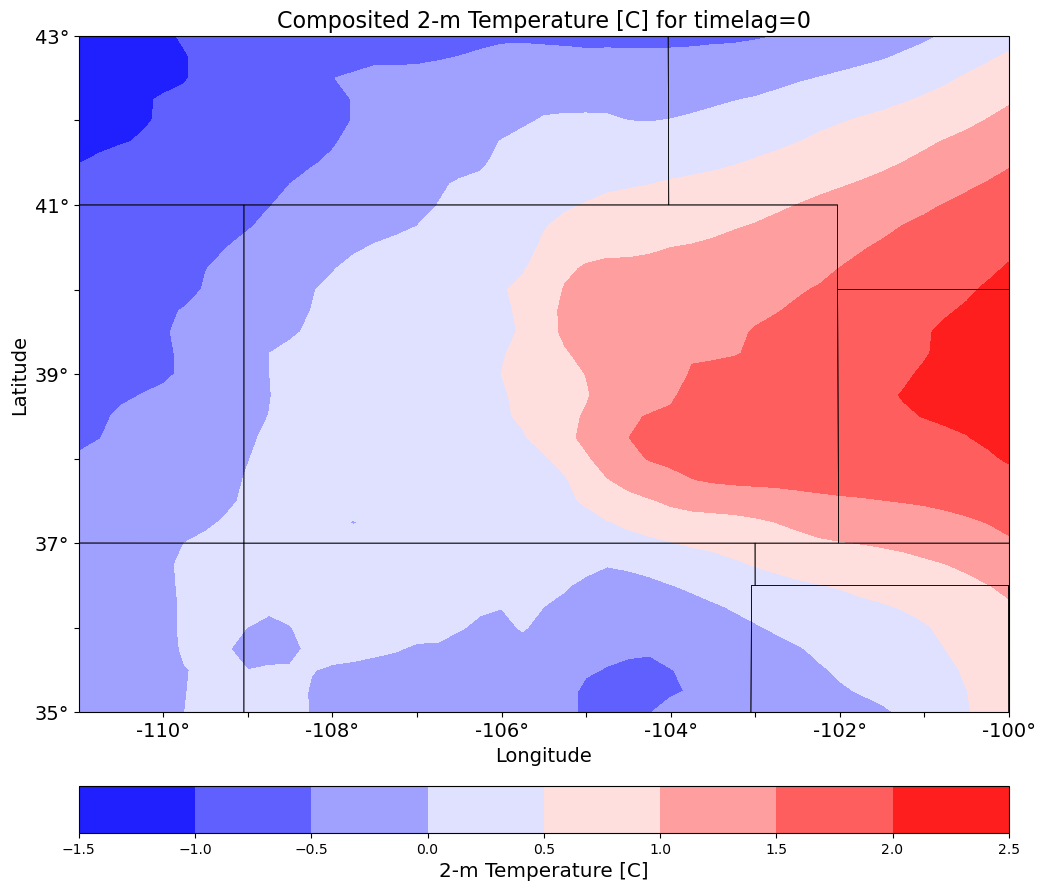

In [38]:
###Plot the composite map for Colorado Region###

#Specify a variable and units to plot#
var_of_interest = '2-m Temperature'
unit_of_interest = 'C'

#Set up the projection that will be used#
mapcrs = ccrs.LambertConformal(central_longitude=-55, central_latitude=45, standard_parallels=(33, 45)) 
mapcrs = ccrs.PlateCarree()

#Set up the projection of the data; if lat/lon then PlateCarree is what you want#
datacrs = ccrs.PlateCarree()

#Start the figure and create plot axes with proper projection#
fig = plt.figure(1, figsize=(12, 12)) 
ax = plt.subplot(111, projection=mapcrs) 
ax.set_extent([-110, -100, 35, 43], ccrs.PlateCarree())  #-110, -100, 35, 43 

#Add geopolitical boundaries for map reference#
ax.add_feature(cfeature.LAND, facecolor="white") 
countries = NaturalEarthFeature(category="cultural", scale="110m", facecolor="none", name="admin_0_boundary_lines_land") 
ax.add_feature(countries, linewidth=0.5, edgecolor="black") 
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5) 
ax.coastlines('50m', linewidth=0.8)

#Add the fcontours#
#temp_levels = np.arange(264, 289, 0.5)
#temp_levels_anom = np.arange(-8, 8.5, 0.5)
#temp_levels_std = np.arange(4, 7.1, 0.1)
#dew_levels = np.arange(260, 275, 0.5)
#dew_levels_anom = np.arange(-3.5, 3.7, 0.2)
#dew_levels_std = np.arange(3.5, 6.6, 0.1)
#mslp_levels = np.arange(1004, 1025, 1)
#u_v_levels = np.arange(-8, 4.5, 0.5)
#thetaE_levels = np.arange(288, 313, 1)
#FLF_levels = np.arange(-2.5, 0.5, 0.1)
#pw_levels = np.arange(0, 14.5, 0.5)
#omega_levels = np.arange(-1, 1.05, 0.05)
#precip_levels = np.arange(0, 0.00014, 0.00001)
#ptype_levels = np.arange(0, 9, 1)
temp_comp_cf = plt.contourf(var_data_lons, var_data_lats, composite_avg, levels=None, cmap="bwr", alpha=1, transform=ccrs.PlateCarree(), label="2-m Temp")

#Colorbar and contour labels#
cb = fig.colorbar(temp_comp_cf, orientation='horizontal', pad=0.08, extendrect=True, aspect=20, shrink=1)
cb.set_label(f'{var_of_interest} [{unit_of_interest}]', size='x-large') #FLF [K/m^3 * 10^14]

#Fix the lats and lon values#
ax.set_xticks(range(-111, -99, 1), crs=ccrs.PlateCarree())
ax.set_yticks(range(35, 44, 1), crs=ccrs.PlateCarree())
x_ticks = [-110,-108,-106,-104,-102,-100]
x_tick_labels = ['-110°','-108°','-106°','-104°','-102°','-100°']
y_ticks = [35,37,39,41,43]
y_tick_labels = ['35°','37°','39°','41°','43°']
plt.xticks(x_ticks, x_tick_labels)
plt.yticks(y_ticks, y_tick_labels)
ax.tick_params(axis='both', which='major', labelsize=14)

#Plot the longitude and latitude#
ax.set_xticks(range(-110, -99, 1), crs=ccrs.PlateCarree())
ax.set_yticks(range(35, 44, 1), crs=ccrs.PlateCarree())
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
plt.title(f'Composited {var_of_interest} [{unit_of_interest}] for timelag={time_lag}', fontsize=16) 

plt.show()

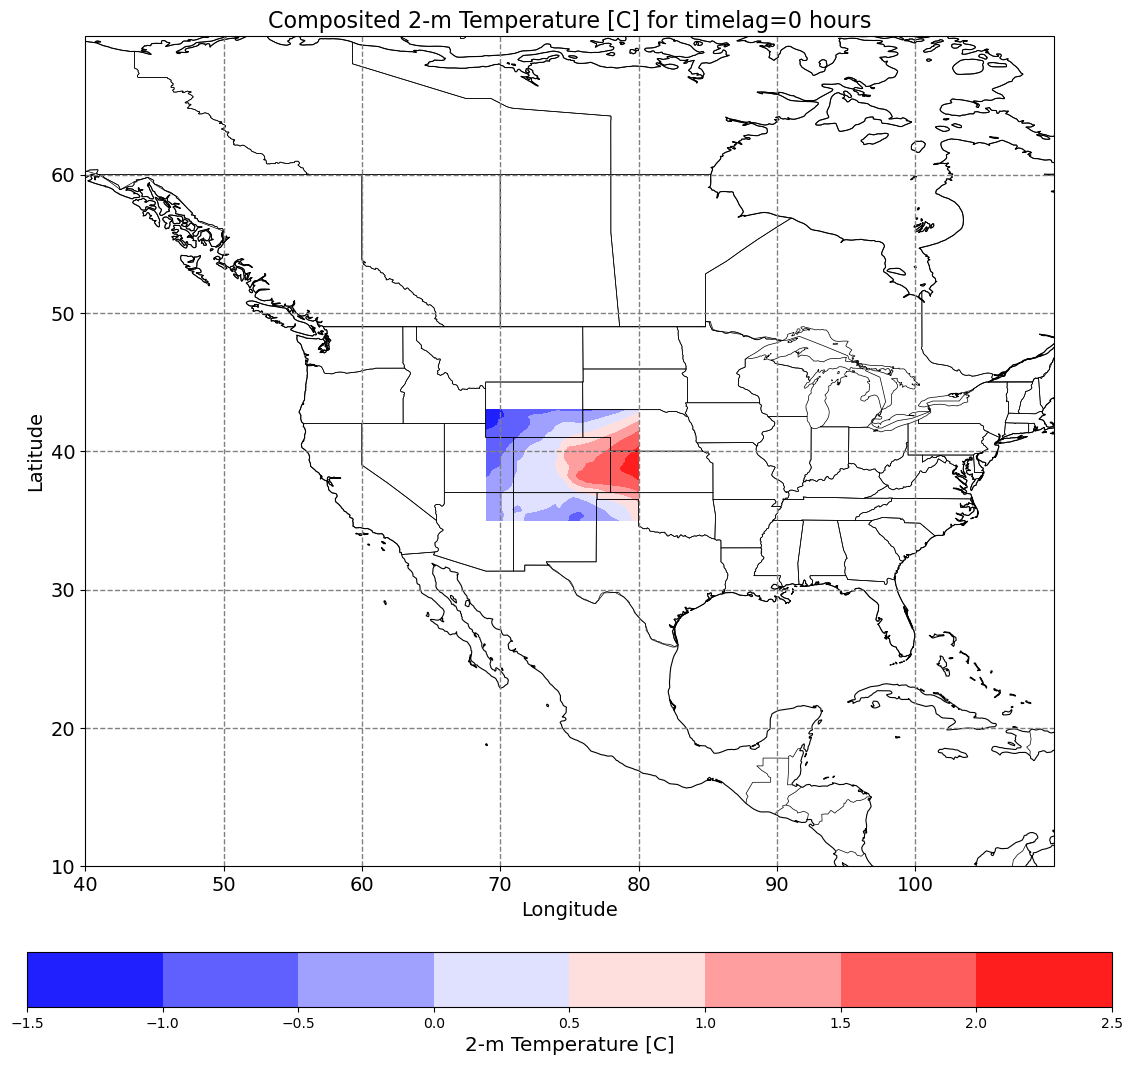

In [39]:
###Plot the composite map for Full Domain###

#Set up the projection that will be used#
mapcrs = ccrs.LambertConformal(central_longitude=-55, central_latitude=45, standard_parallels=(33, 45)) 
mapcrs = ccrs.PlateCarree(central_longitude=180)

#Set up the projection of the data; if lat/lon then PlateCarree is what you want#
datacrs = ccrs.PlateCarree(central_longitude=180)

#Start the figure and create plot axes with proper projection#
fig = plt.figure(1, figsize=(14, 14)) 
ax = plt.subplot(111, projection=mapcrs) 
ax.set_extent([220, 290, 10, 70], ccrs.PlateCarree())  #-110, -100, 35, 43 
gl = ax.gridlines(crs=ccrs.PlateCarree(),linestyle="--", linewidth=1, color='grey', alpha=1)

#Add geopolitical boundaries for map reference#
ax.add_feature(cfeature.LAND, facecolor="white") 
countries = NaturalEarthFeature(category="cultural", scale="110m", facecolor="none", name="admin_0_boundary_lines_land") 
ax.add_feature(countries, linewidth=0.5, edgecolor="black") 
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5) 
ax.coastlines('50m', linewidth=0.8)

#Add the fcontours#
#pw_levels = np.arange(0, 12.5, 0.1)
#msl_levels = np.arange(1002, 1030, 2)
#geop_levels = np.arange(940, 1080, 8)
#omega_levels = np.arange(-1.2, 1.3, 0.1)
#temp_levels = np.arange(-24, 26, 2)
#wind_levels_u = np.arange(-8, 60, 4)
#wind_levels_v = np.arange(-25, 25, 3)
#wind_speed_levels = np.arange(0, 60, 4)
#OLR_levels = np.arange(1.1, 0.52, 0.02)
temp_comp_cfld = plt.contourf(var_data_lons, var_data_lats, composite_avg, levels=None, cmap="bwr", alpha=1, transform=ccrs.PlateCarree(), label="2-m Temp")

#Add labels to the contours#
#plt.clabel(temp_comp_cfld, inline=True, fontsize=8, fmt='%1.1f')

#Colorbar and contour labels#
cbld = fig.colorbar(temp_comp_cfld, orientation='horizontal', pad=0.08, extendrect=True, aspect=20, shrink=1)
cbld.set_label(f'{var_of_interest} [{unit_of_interest}]', size='x-large') #FLF [K/m^3 * 10^14]

#Fix the lats and lon values#
#ax.set_xticks(range(-180, -70, 10), crs=ccrs.PlateCarree())
ax.set_yticks(range(10, 70, 10), crs=ccrs.PlateCarree())
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xticks(range(220, 290, 10), crs=ccrs.PlateCarree())

#Set labels for plot#
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
plt.title(f'Composited {var_of_interest} [{unit_of_interest}] for timelag={time_lag} hours', fontsize=16) 

plt.show()